In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from order_book import *
from ml import *
from ml_models_pt import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Processing

In [2]:
bucket_snapshots = load_as_bucket_snapshots(
    folder = 'data/',
    contract = 'CAKEUSDT',
    start_date = datetime(2025, 3, 20),
    end_date = datetime(2025, 4, 9),
    td = timedelta(seconds=20),
    num_buckets = 10,
    bucket_size = 0.01)

2025-03-20
2025-03-21
2025-03-22
2025-03-23
2025-03-24
2025-03-25
2025-03-26
2025-03-27
2025-03-28
2025-03-29
2025-03-30
2025-03-31
2025-04-01
2025-04-02
2025-04-03
2025-04-04
2025-04-05
2025-04-06
2025-04-07
2025-04-08
2025-04-09


In [ ]:
X_data, X_aux, Y_data = build_bucket_change_data_set(
    bucket_snapshots=bucket_snapshots,
    horizon=6,
    step_size=5,
    window_len=50)

In [11]:
train_split = int(len(X_data) * 0.8)
x_train, x_train_aux, y_train = X_data[:train_split], X_aux[:train_split], Y_data[:train_split]
x_val, x_val_aux, y_val = X_data[train_split:], X_aux[train_split:], Y_data[train_split:]

In [12]:
# Compute mean and std along the samples axis (axis 0)
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)

# Normalize while preserving 3D structure
x_train = (x_train - train_mean) / train_std
x_val = (x_val - train_mean) / train_std

In [13]:
target_std = np.std(y_train, axis=0)

y_train = y_train / target_std
y_val = y_val / target_std

### Visualization

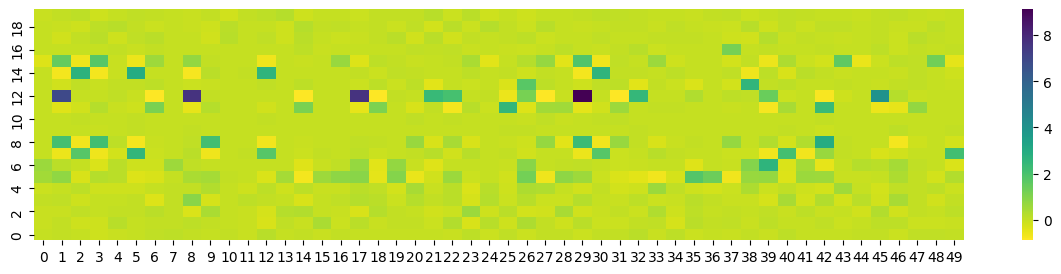

In [14]:
plt.figure(figsize=(15, 3))
sns.heatmap(X_data[1000].T, cmap='viridis_r') #, vmin=-0.5, vmax=0.5)
plt.gca().invert_yaxis()
plt.show()

In [15]:
#plt.hist(y_val)
#plt.show()
#print(y_val.mean())
(y_val < 0).sum()/len(y_val)

np.float64(0.42650736315643234)

In [17]:
20*50/60

16.666666666666668

### Model Training

In [18]:
train_dataset = OrderBookDataset(x_train, x_train_aux, y_train)
val_dataset = OrderBookDataset(x_val, x_val_aux, y_val)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [36]:
model = OrderBookModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
trained_model, losses = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

In [ ]:
# Evaluate with your test data
metrics = evaluate_trend_prediction(trained_model, x_train, x_train_aux, y_train)

In [ ]:
# Evaluate with your test data
metrics = evaluate_trend_prediction(trained_model, x_val, x_val_aux, y_val)